In [219]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sym.init_printing()

# Résolution numérique d'EDP

Ici, on s'intéresse à la résolution de l'*équation de la chaleur*
$$
\begin{aligned}
\frac{\partial u}{\partial t} &= D\frac{\partial^2 u}{\partial x^2} \\
u(x,0) &= 290e^{-25x^2} \\
\partial_xu(0,t) = \partial_xu(1,t) &= 0\quad\text{(Conditions aux limites de Neumann)}
\end{aligned}
$$
sur un domaine rectangulaire de l'espace-temps $\Omega = [0,1]\times[0,T]$. 

Pour cela, on va discrétiser $\Omega$ sous la forme $(j\Delta x,n\Delta t)_{j,n}$, $0\le j< J$ et $0\le n< N$.

In [251]:
T = 0.2 # temps de la simulation numérique

Nmax = 1000
time_s = np.linspace(0,T,Nmax)
dt = T/Nmax

Jmax = 100
X_s = np.linspace(0,1,Jmax)
dx = 1/Jmax

spacetime = np.meshgrid(X_s, time_s)

On pose, pour tout $(j,n)\in [\![0,J-1]\!]\times[\![0,N-1]\!]$, $u_j^n := u(j\Delta x,n\Delta t)$. Alors, en discrétisant les dérivées,
$$
\frac{\partial u}{\partial t} \approx \frac{u_j^{n+1}-u_j^n}{\Delta t}\quad \text{et}\quad \frac{\partial^2u}{\partial x^2}\approx \frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1} + u_{j+1}^n - 2u_j^n + u_{j-1}^n}{2(\Delta x)^2}.
$$

On pose $r:=\frac{D\Delta t}{(\Delta x)^2}$ ; alors on est amené au système d'équations
$$
-ru_{j+1}^{n+1}+(1+2r)u_j^{n+1} - ru_{j-1}^{n+1} = (1-2r)u_j^n + r\left(u_{j+1}^n+u_{j-1}^n\right)\quad \forall (j,n)\in[\![0,J-1]\!]\times[\![0,N-1]\!].
$$

Le problème ici c'est que $u_{-1}^n$ et $u_J^n$ ne sont pas définis. Avec les conditions aux limites
$$
\partial_xu(0,t) = \partial_xu(1,t) = 0
$$
on a
$$
u_{-1}^n = u_0^n \quad\text{et}\quad u_{J}^n = u_{J-1}^n\quad\forall n
$$

ce qui conduit à
$$
\begin{aligned}
-ru_1^{n+1}+ (1+r)u_0^{n+1} &= (1-r)u_0^n + ru_1^n \\
(1+r)u_{J-1}^{n+1}-ru_{J-2}^{n+1} &= (1-r)u_{J-1}^n + ru_{J-2}^n
\end{aligned}
$$

On pose $\mathbf U^n = \begin{bmatrix} u_0^{n} \\ \vdots \\ u_{J-1}^n \end{bmatrix}$ le vecteur d'état du système à l'instant $t_n = n\Delta t $ et les matrices
$$\mathbf A 
= \begin{bmatrix}
1+r   & -r  &        &         &       \\
-r & 1+2r   & -r      &        &  \\
   & \ddots & \ddots & \ddots &  \\
   &        & -r      & 1+2r   & -r \\
   &        &        & -r      &  1+r      
\end{bmatrix}
$$
et
$$\mathbf B 
= \begin{bmatrix}
1-r   & r  &        &         &       \\
r & 1-2r   & r      &        &  \\
   & \ddots & \ddots & \ddots &  \\
   &        & r      & 1-2r   & r \\
   &        &        & r      &  1-r      
\end{bmatrix}.
$$


On a donc la relation de passage d'un état au suivant :
$$
\mathbf A\mathbf U^{n+1} = \mathbf B\mathbf U^n,
$$
mais $\mathbf A$ étant inversible,
$$
\mathbf U^{n+1} = \mathbf A^{-1}\mathbf B\mathbf U^n
$$

In [280]:
def process_matrix(J):
    r = 6*dt/(dx*dx)
    print(r)
    A = np.zeros((J,J))
    B = np.zeros((J,J))
    for j in range(0,J):
        if j == 0 or j== J-1:
            A[j][j] = 1 + r
            B[j][j] = 1 - r
        else:
            A[j][j] = 1 +2* r
            B[j][j] = 1-2*r
        if j > 0:
            A[j][j-1] = - r
            B[j][j-1] = r
        if j < J-1:
            A[j][j+1] = - r
            B[j][j+1] = r
    return A,B

In [281]:
A,B = process_matrix(Jmax)
A,B

12.0


(array([[ 13., -12.,   0., ...,   0.,   0.,   0.],
        [-12.,  25., -12., ...,   0.,   0.,   0.],
        [  0., -12.,  25., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   0., ...,  25., -12.,   0.],
        [  0.,   0.,   0., ..., -12.,  25., -12.],
        [  0.,   0.,   0., ...,   0., -12.,  13.]]),
 array([[-11.,  12.,   0., ...,   0.,   0.,   0.],
        [ 12., -23.,  12., ...,   0.,   0.,   0.],
        [  0.,  12., -23., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   0., ..., -23.,  12.,   0.],
        [  0.,   0.,   0., ...,  12., -23.,  12.],
        [  0.,   0.,   0., ...,   0.,  12., -11.]]))

In [292]:
C = np.matmul(np.linalg.inv(A),B)
C

array([[ -5.00000000e-01,   3.75000000e-01,   2.81250000e-01, ...,
          4.70315413e-13,   4.05354721e-13,   3.74173588e-13],
       [  3.75000000e-01,  -5.93750000e-01,   3.04687500e-01, ...,
          5.09508364e-13,   4.39134281e-13,   4.05354721e-13],
       [  2.81250000e-01,   3.04687500e-01,  -6.46484375e-01, ...,
          5.91160346e-13,   5.09508364e-13,   4.70315413e-13],
       ..., 
       [  4.70315413e-13,   5.09508364e-13,   5.91160346e-13, ...,
         -6.46484375e-01,   3.04687500e-01,   2.81250000e-01],
       [  4.05354721e-13,   4.39134281e-13,   5.09508364e-13, ...,
          3.04687500e-01,  -5.93750000e-01,   3.75000000e-01],
       [  3.74173588e-13,   4.05354721e-13,   4.70315413e-13, ...,
          2.81250000e-01,   3.75000000e-01,  -5.00000000e-01]])

In [293]:
U0 = 290*np.exp(-25*(X_s-0.5)**2)
np.matmul(C,U0)

array([   3.03263732,    3.07971636,    3.28308183,    3.63414735,
          4.13093257,    4.77683474,    5.57970085,    6.55111413,
          7.70582833,    9.06129845,   10.63726765,   12.45537957,
         14.5387915 ,   16.91177024,   19.59925703,   22.62639198,
         26.01799279,   29.7979857 ,   33.98879041,   38.6106639 ,
         43.68101139,   49.21367573,   55.21821918,   61.69921427,
         68.65556227,   76.07985949,   83.95783252,   92.26786385,
        100.98062873,  110.05886295,  119.45727921,  129.12264662,
        138.99404463,  149.00329836,  159.07559733,  169.13029482,
        179.08187947,  188.84110542,  198.31626209,  207.41455978,
        216.04360291,  224.11291921,  231.53551008,  238.22938604,
        244.11904993,  249.13689134,  253.22445703,  256.33356478,
        258.42723182,  259.48039357,  259.48039357,  258.42723182,
        256.33356478,  253.22445703,  249.13689134,  244.11904993,
        238.22938604,  231.53551008,  224.11291921,  216.04360

In [314]:
def solvaro(U0, animate = False):
    # Condition initiale
    print(len(U0))
    L = [U0]
    for t in time_s:
        L.append(np.matmul(C,L[-1]))
    
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ax.grid(True)
    ax.set_xlabel(r"Position $x$ ($m$)")
    ax.set_ylabel(r"Température $u(x,t)$ ($K$)")
    
    for n in [0, 2, 4, 10, 20]:
        ax.plot(X_s,L[n])

100


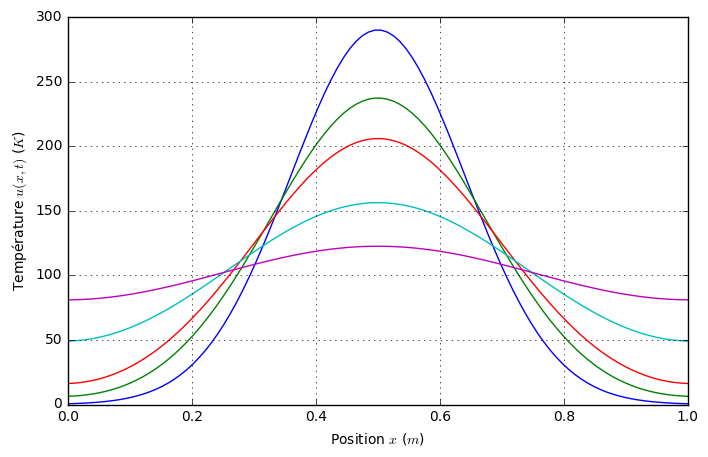

In [313]:
solvaro(U0)